数据集加载完成！
开始训练...
Epoch 1/10: Train Loss: 0.1471, Train Acc: 0.961, Test Acc: 0.983
Epoch 2/10: Train Loss: 0.0461, Train Acc: 0.988, Test Acc: 0.989
Epoch 3/10: Train Loss: 0.0315, Train Acc: 0.992, Test Acc: 0.988
Epoch 4/10: Train Loss: 0.0232, Train Acc: 0.994, Test Acc: 0.990
Epoch 5/10: Train Loss: 0.0183, Train Acc: 0.996, Test Acc: 0.991
Epoch 6/10: Train Loss: 0.0143, Train Acc: 0.997, Test Acc: 0.992
Epoch 7/10: Train Loss: 0.0110, Train Acc: 0.998, Test Acc: 0.991
Epoch 8/10: Train Loss: 0.0090, Train Acc: 0.998, Test Acc: 0.990
Epoch 9/10: Train Loss: 0.0075, Train Acc: 0.999, Test Acc: 0.990
Epoch 10/10: Train Loss: 0.0065, Train Acc: 0.999, Test Acc: 0.991


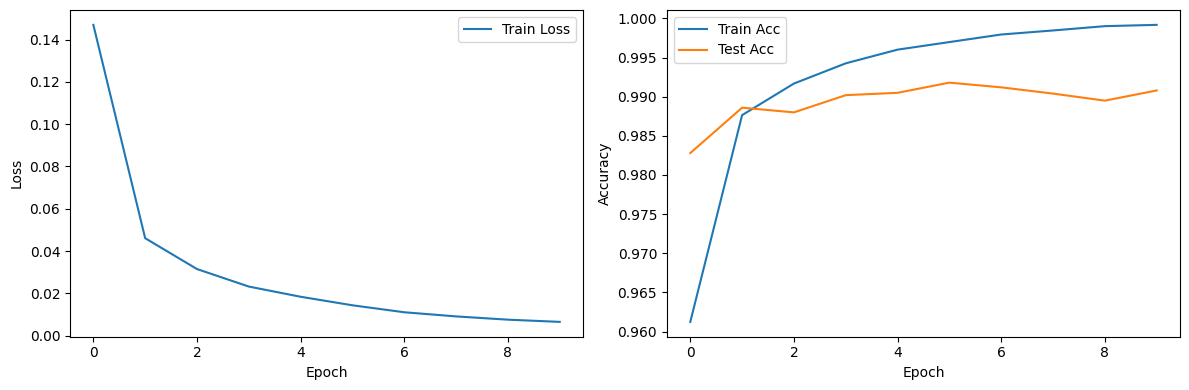

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# 1. 加载MNIST数据集，并返回训练集和测试集的数据加载器
def load_data_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
    print("数据集加载完成！")
    return (
        DataLoader(train_data, batch_size, shuffle=True, num_workers=2),
        DataLoader(test_data, batch_size, shuffle=False, num_workers=2)
    )

# 2. 卷积神经网络模型，使用BatchNorm优化
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)       # 28->24
        self.bn1 = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d(2, 2)         # 24->12
        self.conv2 = nn.Conv2d(10, 20, 3)      # 12->10
        self.bn2 = nn.BatchNorm2d(20)

        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.bn_fc = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn_fc(self.fc1(x)))
        x = self.fc2(x)
        return x


# 3. 训练模型
def train_model(net, train_iter, test_iter, num_epochs=10, lr=0.1):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loss_list, train_acc_list, test_acc_list = [], [], []
    print("开始训练...")

    for epoch in range(num_epochs):
        net.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for X, y in train_iter:
            output = net(X)
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (output.argmax(dim=1) == y).sum().item()
            total_samples += y.size(0)

        train_loss = total_loss / len(train_iter)
        train_acc = total_correct / total_samples

        # 测试
        net.eval()
        test_correct, test_samples = 0, 0
        with torch.no_grad():
            for X, y in test_iter:
                output = net(X)
                test_correct += (output.argmax(dim=1) == y).sum().item()
                test_samples += y.size(0)
        test_acc = test_correct / test_samples

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.3f}, '
              f'Test Acc: {test_acc:.3f}')

    # 可视化
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    torch.manual_seed(42)
    batch_size = 256
    num_epochs = 10
    learning_rate = 0.1

    train_iter, test_iter = load_data_mnist(batch_size)
    model = ConvNet()
    train_model(model, train_iter, test_iter, num_epochs, learning_rate)
